# Summary of this Notebook

In this notebook, we prepare the data from the [last notebook](./01_data_processing.ipynb) to be processed by the chess engine [Stockfish](https://github.com/official-stockfish/Stockfish) and our machine learning algorithms.  We properly format the strings representing game histories, then we verify that all such formatted histories can be properly read.  In the process, we run through some example games and demonstrate how to get Stockfish evaluations and "top moves" for each of the positions in the game.  We also test how long it takes for Stockfish to extract all the information we need from these games.

Afterwards, we drop those games that took fewer than 10 turns to complete.  We then reorganize the information in our dataframes into a more convenient format.  Finally, we perform a train/test/validate split on our data and export the split, prepared data as CSV files.

## A note on using Stockfish to evaluate human players' moves

We plan to use Stockfish to evaluate a new player's moves and positions in her first game.  We will then use these move and position evaluations, along with information about the new player's upcoming opponent, to predict the results of her *2nd game*.  Thus, it is essential that we can obtain reasonably accurate evaluations of the positions and moves made in the new player's first game.  However, the way in which Stockfish evaluates moves and positions can vary greatly depending on how one sets its parameters.

We initialize Stockfish with default parameters (other than those relating to CPU and memory usage) and a search depth of 15 - the default value.  Table 8 of [this paper](https://web.ist.utl.pt/diogo.ferreira/papers/ferreira13impact.pdf) reports that this makes Stockfish's strength approximately equivalent to a player with an Elo rating of 2563 (95% confidence interval = \[2498, 2623\]).

Stockfish does not evaluate positions in exactly the same way that a human does, and hence it does not generally play in the same way that a human would: it often prefers "risky" moves that may yield high payoffs *assuming you (Stockfish) play perfectly over the course of the next several moves*, whereas a human player at a similar Elo rating would typically prefer a "safer" move that may not have as much upside potential but guarantees a reasonably good payoff even if you do not play perfectly.

An Elo/Glicko score of about 2400 represents [approximately the top 1% of players on Lichess.org](https://lichess.org/stat/rating/distribution/rapid).  Thus, using Stockfish with a search depth of 15 (Elo a little over 2500) equates to a player that is overall stronger than the vast majority of human players, but not stronger than all human players.  We estimate that using a search depth of 15 will be a *reasonable* way to evaluate the moves and positions of typical human players; indeed, this is perhaps why a search depth of 15 is the default value.

## Instructions for running this notebook

1. Download the [Stockfish App](https://github.com/official-stockfish/Stockfish).  This can be installed on Mac with the terminal command `brew install stockfish`.
2. Install the `stockfish` [Python API wrapper](https://pypi.org/project/stockfish/).  This can be installed with `pip install stockfish`.
3. Install the `chess` library with `pip install chess`.
4. Find the path to your Stockfish app's binary (or executable) file.  Input it in the cell below:

In [1]:
# CHANGE THIS CELL TO POINT TO THE STOCKFISH APP INSTALLED ON YOUR MACHINE
stockfish_path = '/opt/homebrew/bin/stockfish'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import itertools

from stockfish import Stockfish
import chess

from sklearn.model_selection import train_test_split

from helper_functions import format_game

### Ignore `FutureWarning`s in this notebook

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Import

In [4]:
games_1st = pd.read_csv('../data/processed/new_pl_1st_games.csv', index_col='name_of_pl_playing_1st_game')
games_2nd = pd.read_csv('../data/processed/new_pl_2nd_games.csv', index_col='name_of_pl_playing_2nd_game')
games_opp = pd.read_csv('../data/processed/new_pl_2nd_opp_previous_games.csv', index_col='new_pl_to_be_played_next_game')

In [5]:
len(games_1st), len(games_2nd), len(games_opp)

(24284, 24284, 24284)

In [6]:
games_1st.head(1)

,Event,White,Black,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,TimeControl,Termination,AN,datetime,timestamp,both_players_1st_game
name_of_pl_playing_1st_game,,,,,,,,,,,,,,
sereno,Classical,fabikim,sereno,1-0,1630,1500,7.0,-7.0,420+5,Normal,1. e4 e5 2. Nf3 d6 3. Bc4 Nc6 4. d3 Na5 5. Na3...,2016-06-30 22:00:02,1.467324e+09,0


# Format Game Strings

The sequence of moves given in the `AN` are in [Algebraic Notation](https://en.wikipedia.org/wiki/Algebraic_notation_(chess)).  However, their default format is not one that can be read by *either* Stockfish or the "chess" library, as they contain superfluous numbers and symbols.  For example:

In [7]:
game1 = games_1st.loc['sereno', 'AN']
game1

'1. e4 e5 2. Nf3 d6 3. Bc4 Nc6 4. d3 Na5 5. Na3 Nxc4 6. Nxc4 a6 7. Ng5 h6 8. Nf3 Be6 9. Ne3 Be7 10. h3 Bg5 11. O-O Ne7 12. Nxg5 hxg5 13. Qf3 Qd7 14. g4 g6 15. c3 f5 16. exf5 gxf5 17. d4 fxg4 18. hxg4 Bxg4 19. Nxg4 O-O-O 20. Bxg5 Qf5 21. Qxf5+ Nxf5 22. Bxd8 Kxd8 23. Kg2 Rg8 24. Kf3 exd4 25. cxd4 Nxd4+ 26. Kf4 Ne2+ 27. Ke3 Re8+ 28. Kf3 Nd4+ 29. Kg3 Nf5+ 30. Kf4 Nh4 31. Rg1 Rf8+ 32. Kg3 Nf5+ 33. Kh2 Nd4 34. Rg3 Rxf2+ 35. Nxf2 1-0'

These moves are listed in a format where, when there is no ambiguity, they only specify the *target square* to which a piece is moving.  For example, the opening move "e4" could more expansively be written out as "e2e4" (the piece that was on square e2 moved to square e4), but it is recorded as simply "e4" since the piece on e2 (the king's pawn) is the only piece that could have moved to e4 from the opening board state.

This abbreviated formatting is one that the `chess` library can handle, but Stockfish cannot read these abreviated moves.  To use Stockfish to get evaluations of the various board positions realized during a game, we will need to first feed the moves of the game to a `Board` object from `chess`, then use the `Board` object to get the positions in [Forsyth-Edwards Notation (FEN)](https://en.wikipedia.org/wiki/Forsyth%E2%80%93Edwards_Notation) to feed to Stockfish.

However, before any of this is possible, we must remove the unnecessary numbers and symbols that appear in the game strings, such as the "1.", "2.", ... and the "1-0" at the end of the game.

About 15% of the games in our data also come with Stockfish evaluations that were automatically carried out by Lichess.org.  These games give an evaluation in braces of the form `{ [%eval (score)] }`, where the `(score)` is White's advantage measured in centipawns.  Near the end of the game, these scores transition into "moves until checkmate" numbers; for example, a score of "#1" means "White can checkmate in 1 move" and a score of "#-3" means "Black can checkmate in 3 moves."  This games might also contain further notation, such as question marks (?) or exclamation marks (!) in certain combinations denoting whether Stockfish thinks a move was unexpected, strong, etc.

**Note**: These Stockfish evlauations need not match the Stockfish evaluations that our own code will produce.  This is because Stockfish can be set up with many different parameter values and those used by Lichess's automatic evaluations need not be the same as those we will use.

In [8]:
#An example with automatically-added Stockfish evaluations
game2 = games_1st.loc['Grevling', 'AN']
game2

'1. e4 { [%eval 0.29] } 1... e5 { [%eval 0.27] } 2. Nf3 { [%eval 0.23] } 2... Nc6 { [%eval 0.21] } 3. Bb5 { [%eval 0.18] } 3... d6 { [%eval 0.35] } 4. O-O { [%eval 0.45] } 4... Bd7 { [%eval 0.56] } 5. Nc3 { [%eval 0.33] } 5... a6 { [%eval 0.77] } 6. Bc4?! { [%eval 0.21] } 6... Nf6?! { [%eval 1.11] } 7. a3?! { [%eval 0.18] } 7... Be7 { [%eval 0.2] } 8. b4 { [%eval -0.04] } 8... O-O { [%eval -0.16] } 9. d3 { [%eval 0.04] } 9... Rb8 { [%eval 0.13] } 10. Be3 { [%eval 0.18] } 10... Bg4 { [%eval 0.29] } 11. h3 { [%eval 0.23] } 11... Bh5 { [%eval 0.14] } 12. Nd5 { [%eval 0.17] } 12... Nxd5 { [%eval 0.21] } 13. exd5 { [%eval -0.13] } 13... Na7? { [%eval 2.38] } 14. d4? { [%eval -0.17] } 14... e4 { [%eval -0.19] } 15. g4 { [%eval -0.41] } 15... Bxg4?! { [%eval 0.26] } 16. hxg4 { [%eval 0.31] } 16... exf3 { [%eval 0.65] } 17. Qxf3 { [%eval 0.68] } 17... Nb5?! { [%eval 1.46] } 18. Qh3?! { [%eval 0.74] } 18... Bg5?! { [%eval 1.69] } 19. Kg2? { [%eval 0.0] } 19... Bxe3 { [%eval 0.0] } 20. fxe3 { [%

### Formatting these example game strings

We will use the `format_game` function from the [helper functions](./helper_functions.py) to format these games strings into a format that will be easy for the `chess` package to read.

In [9]:
#Formatting the first example game
game1 = format_game(game1)
game1

'e4 e5 Nf3 d6 Bc4 Nc6 d3 Na5 Na3 Nxc4 Nxc4 a6 Ng5 h6 Nf3 Be6 Ne3 Be7 h3 Bg5 O-O Ne7 Nxg5 hxg5 Qf3 Qd7 g4 g6 c3 f5 exf5 gxf5 d4 fxg4 hxg4 Bxg4 Nxg4 O-O-O Bxg5 Qf5 Qxf5+ Nxf5 Bxd8 Kxd8 Kg2 Rg8 Kf3 exd4 cxd4 Nxd4+ Kf4 Ne2+ Ke3 Re8+ Kf3 Nd4+ Kg3 Nf5+ Kf4 Nh4 Rg1 Rf8+ Kg3 Nf5+ Kh2 Nd4 Rg3 Rxf2+ Nxf2'

In [10]:
#Formatting the second example game
game2 = format_game(game2)
game2

'e4 e5 Nf3 Nc6 Bb5 d6 O-O Bd7 Nc3 a6 Bc4 Nf6 a3 Be7 b4 O-O d3 Rb8 Be3 Bg4 h3 Bh5 Nd5 Nxd5 exd5 Na7 d4 e4 g4 Bxg4 hxg4 exf3 Qxf3 Nb5 Qh3 Bg5 Kg2 Bxe3 fxe3 c6 Bd3 cxd5 Qxh7#'

## Formatting all games in the three dataframes

The `games_opp` dataframe contains a few rows that are missing games.  These missing rows correspond to new players whose 2nd-game opponents have *no previous game* during the month in our data set (either because they are themselves completely new to Lichess.org or because they simply didn't play any other games so far that month).  Thus, we must write our mapping function in a way that can handle the possibility of missing values:

In [11]:
for df in games_1st, games_2nd, games_opp:
    df['AN'] = df['AN'].map(lambda x : format_game(x) if pd.notnull(x) else x)

In [12]:
#Check the games_opp dataframe: an observation where the game is not missing
games_opp[games_opp['2nd_game_opp_had_no_previous_game']==0].head(1)

,Event,White,Black,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,TimeControl,Termination,AN,datetime,timestamp,user_to_play_new_pl_next_game,both_users_to_play_new_pl_next,2nd_game_opp_had_no_previous_game
new_pl_to_be_played_next_game,,,,,,,,,,,,,,,,
farfalla,Classical,Claudiosparov,gonzo0506,0-1,1432.0,1355.0,-14.0,13.0,600+0,Normal,a3 d5 b4 b5 Bb2 Nc6 e3 e5 d4 e4 f3 Bf5 g4 Qh4+...,2016-06-30 22:01:02,1.467324e+09,gonzo0506,0,0


In [13]:
#Check the games_opp dataframe: some observations where the game IS missing
games_opp[games_opp['2nd_game_opp_had_no_previous_game']==1].head(3)

,Event,White,Black,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,TimeControl,Termination,AN,datetime,timestamp,user_to_play_new_pl_next_game,both_users_to_play_new_pl_next,2nd_game_opp_had_no_previous_game
new_pl_to_be_played_next_game,,,,,,,,,,,,,,,,
xmen3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
alfa_khoirin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
Manilkin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1


# Playing out a game using the game string

## Using `chess` Board objects to make moves

In [14]:
game3 = games_opp.loc['Sanacbra', 'AN']
moves = game3.split(' ')
print(moves)

['e4', 'e5', 'Nf3', 'Nf6', 'Nxe5', 'd6', 'Nf3', 'Nxe4', 'Bc4', 'Be7', 'O-O', 'O-O', 'Re1', 'Nf6', 'd4', 'a6', 'd5', 'h6', 'Nc3', 'b5', 'Be2', 'Bb7', 'a3', 'Nh7', 'Ne4', 'Nf6', 'Nxf6+', 'Bxf6', 'c4', 'bxc4', 'Bxc4', 'Nd7', 'Rb1', 'Nb6', 'Ba2', 'Qd7', 'b4', 'Qb5', 'a4', 'Nxa4', 'Nd4', 'Bxd4', 'Qxd4', 'Nb6', 'Bb2', 'Qd7', 'Qxg7#']


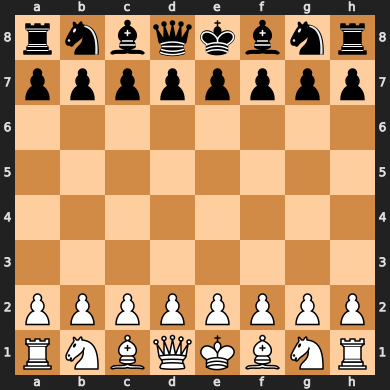

In [15]:
#Initialize an empty chessboard
board = chess.Board()
board

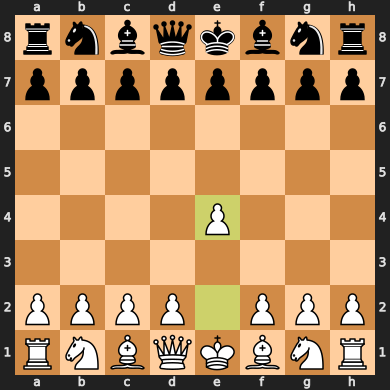

In [16]:
#Make a move using standard algebraic notation (SAN), taken from our list of moves
board.push_san(moves[0])
board

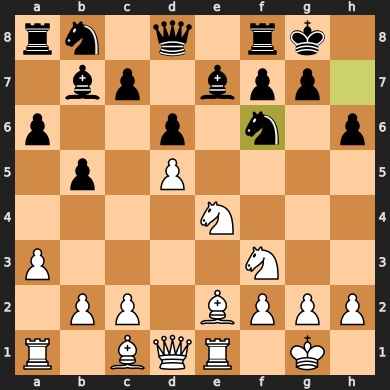

In [17]:
#Make the next 25 moves
for move in moves[1:26]:
    board.push_san(move)
    
board

In [18]:
# Get the FEN string representing the current state of the game
fen = board.fen()
fen

'rn1q1rk1/1bp1bpp1/p2p1n1p/1p1P4/4N3/P4N2/1PP1BPPP/R1BQR1K1 w - - 3 14'

In [19]:
#Try to make an illegal move: This will throw an IllegalMoveError
# board.push_san('c6')

## Evaluate positions using Stockfish

In [20]:
#Initialize Stockfish with a search depth of 15
sf = Stockfish(stockfish_path, depth=15)

#Set the number of cores and amount of memory Stockfish can use
sf.update_engine_parameters({
    'Threads':1,
    "Hash":2048
})

### Starting board position

In [21]:
#Get the top 10 moves from the initial board position
start = time.time()
top_10_starters = sf.get_top_moves(10)
end = time.time()

top_10_starters

[{'Move': 'e2e4', 'Centipawn': 36, 'Mate': None},
 {'Move': 'c2c4', 'Centipawn': 33, 'Mate': None},
 {'Move': 'd2d4', 'Centipawn': 32, 'Mate': None},
 {'Move': 'g1f3', 'Centipawn': 30, 'Mate': None},
 {'Move': 'g2g3', 'Centipawn': 22, 'Mate': None},
 {'Move': 'e2e3', 'Centipawn': 15, 'Mate': None},
 {'Move': 'c2c3', 'Centipawn': 6, 'Mate': None},
 {'Move': 'a2a3', 'Centipawn': 0, 'Mate': None},
 {'Move': 'b1c3', 'Centipawn': 0, 'Mate': None},
 {'Move': 'b2b3', 'Centipawn': -14, 'Mate': None}]

In [22]:
#How many seconds did it take to get these valuations?
end - start

2.563939094543457

In [23]:
#Get the evaluation (in centipawns of white advantage) of the initial position
start = time.time()
start_evaluation = sf.get_evaluation()
end = time.time()

start_evaluation

{'type': 'cp', 'value': 30}

In [24]:
#How many seconds did it take to get this valuation?
end - start

0.04185295104980469

### Midgame position

In [25]:
#Set the position of Stockfish to the same board position as above (26 moves into the game)
sf.set_fen_position(fen)

In [26]:
#Get the top 10 moves from this position
start = time.time()
top_10_moves = sf.get_top_moves(10)
end = time.time()

top_10_moves

[{'Move': 'e4g3', 'Centipawn': 13, 'Mate': None},
 {'Move': 'e4f6', 'Centipawn': 9, 'Mate': None},
 {'Move': 'e2d3', 'Centipawn': 0, 'Mate': None},
 {'Move': 'e4c3', 'Centipawn': -19, 'Mate': None},
 {'Move': 'd1d4', 'Centipawn': -24, 'Mate': None},
 {'Move': 'e2f1', 'Centipawn': -26, 'Mate': None},
 {'Move': 'd1d3', 'Centipawn': -28, 'Mate': None},
 {'Move': 'e4d2', 'Centipawn': -68, 'Mate': None},
 {'Move': 'c1h6', 'Centipawn': -74, 'Mate': None},
 {'Move': 'f3d2', 'Centipawn': -86, 'Mate': None}]

In [27]:
#How many seconds did it take to get these valuations?
end - start

1.69252610206604

In [28]:
#Get the evaluation (in centipawns of white advantage) of this position
start = time.time()
evaluation = sf.get_evaluation()
end = time.time()

evaluation

{'type': 'cp', 'value': 22}

In [29]:
#How many seconds did it take to get this valuation?
end - start

0.1442699432373047

### Endgame position

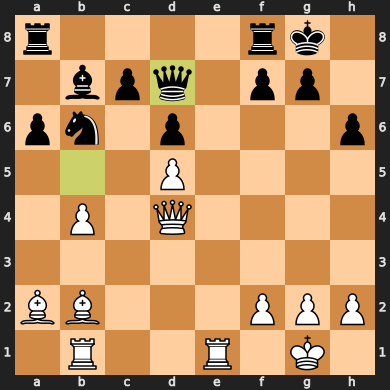

In [30]:
#Initialize a new board
board = chess.Board()

#Make all but the last move of the game
for move in moves[:len(moves)-1]:
    board.push_san(move)
    
board

In [31]:
# Get the FEN string representing the current state of the game
fen = board.fen()
fen

'r4rk1/1bpq1pp1/pn1p3p/3P4/1P1Q4/8/BB3PPP/1R2R1K1 w - - 3 24'

In [32]:
#Set the position of Stockfish to this board position
sf.set_fen_position(fen)

In [33]:
#Get the "top 10" moves from this position (there may be fewer than 10 legal moves)
start = time.time()
top_10_moves = sf.get_top_moves(10)
end = time.time()

top_10_moves

[{'Move': 'd4g7', 'Centipawn': None, 'Mate': 1},
 {'Move': 'e1e7', 'Centipawn': 488, 'Mate': None},
 {'Move': 'b1c1', 'Centipawn': 97, 'Mate': None},
 {'Move': 'h2h3', 'Centipawn': 83, 'Mate': None},
 {'Move': 'b1d1', 'Centipawn': 65, 'Mate': None},
 {'Move': 'e1e3', 'Centipawn': 48, 'Mate': None},
 {'Move': 'h2h4', 'Centipawn': 35, 'Mate': None},
 {'Move': 'b2a1', 'Centipawn': 24, 'Mate': None},
 {'Move': 'b1a1', 'Centipawn': 19, 'Mate': None},
 {'Move': 'f2f3', 'Centipawn': 13, 'Mate': None}]

In [34]:
#How many seconds did it take to get these valuations?
end - start

3.492755889892578

In [35]:
#Get the evaluation (in moves until Checkmate) of this position
start = time.time()
evaluation = sf.get_evaluation()
end = time.time()

evaluation

{'type': 'mate', 'value': 1}

In [36]:
#How many seconds did it take to get this valuation?
end - start

0.0011229515075683594

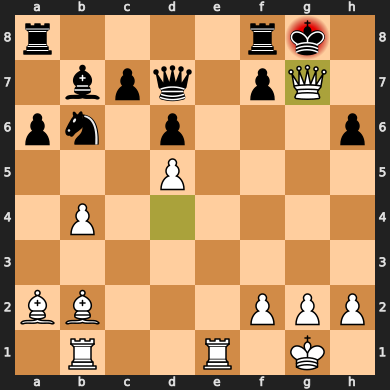

In [37]:
#Look at the final board position
board.push_san(moves[len(moves)-1])
board

# Get the evaluations and top moves for an entire game

As we run through the games, we will only need to get the "top moves" for *one* of the two players.  For example, if the new player is playing White, then we will want to extract the following information:
1. The evaluations of all board positions actually achieved in the game.
2. The top 10 moves that were available to the *White* player during each of her turns.

We will use these "top 10" moves to evaluate how good of a move the White player made out of the moves she *could have made*.  However, we do not need to find these "top 10 moves" for her opponent's turns, as we're not trying to directly evaluate how well the new player's *opponent* played during the game (other than through the information that is captured by the actual positions realized during the game).

In what follows, we check how long it takes to complete this task.  For comparison, we also check how long this task would take if we only got the "top 10 moves" (and not the evaluations), as well as how long it would take if we got both the evaluations and the top 10 moves for *both players*.

### Getting the evaluations for all positions, and the top 10 moves for a single player

In [38]:
#Get the information mentioned above, and see how long it takes
start = time.time()

board = chess.Board()
moves_dict = {}

for i, move in enumerate(moves):
    moves_dict[i] = {}
    
    #Set Stockfish's position to the current position
    sf.set_fen_position(board.fen())
    
    #Get the evaluation of the current position
    moves_dict[i]['eval'] = sf.get_evaluation()
    
    #If this is the White player's turn, also get the top 10 moves
    if i%2 == 0:
        moves_dict[i]['top_10'] = sf.get_top_moves(10)
        
    #Finally, make the move that was actually played
    board.push_san(move)
        
end = time.time()

end-start

50.71720790863037

In [39]:
#How many seconds did this take per move in the game?
(end-start)/len(moves)

1.079089529970859

### Only getting the top 10 moves (not the evaluations)

In [40]:
#Get the information mentioned above, and see how long it takes
start = time.time()

board = chess.Board()
moves_dict = {}

for i, move in enumerate(moves):
    moves_dict[i] = {}
    
    #Set Stockfish's position to the current position
    sf.set_fen_position(board.fen())
    
    #If this is the White player's turn, also get the top 10 moves
    if i%2 == 0:
        moves_dict[i]['top_10'] = sf.get_top_moves(10)
        
    #Finally, make the move that was actually played
    board.push_san(move)
        
end = time.time()

end-start

44.96898031234741

In [41]:
#How many seconds did this take per move in the game?
(end-start)/len(moves)

0.9567868151563279

As we can see, electing not to get the evaluations did not save us much time.

### Getting the evaluations and top 10 moves for *both* players

In [42]:
#How much longer does this take if we also get the top 10 moves for each of the opponent's turns?
start = time.time()

board = chess.Board()
moves_dict = {}

for i, move in enumerate(moves):
    moves_dict[i] = {}
    
    #Set Stockfish's position to the current position
    sf.set_fen_position(board.fen())
    
    #Get the evaluation of the current position
    moves_dict[i]['eval'] = sf.get_evaluation()
    
    #Get the top 10 moves, regardless of whose turn it is
    moves_dict[i]['top_10'] = sf.get_top_moves(10)
        
    #Finally, make the move that was actually played
    board.push_san(move)
        
end = time.time()

end-start

86.73001790046692

In [43]:
#How many seconds did this take per move in the game?
(end-start)/len(moves)

1.8453195297971685

As we can see, choosing to get the top 10 moves for *both* players made things take about twice as long.

## Repeating the exercise on a different game

In [44]:
#How many moves were in the game we were using above?
len(moves)

47

In [45]:
#Choose another random game
moves = games_1st.iloc[1234]['AN'].split(' ')
print(moves)

['e4', 'd6', 'd4', 'Nf6', 'Nc3', 'g6', 'Nf3', 'Bg7', 'Bd3', 'O-O', 'Be3', 'c6', 'Qd2', 'Re8', 'O-O-O', 'a6', 'Ne1', 'b5', 'f3', 'Nbd7', 'g4', 'Nb6', 'h4', 'Nc4', 'Bxc4', 'bxc4', 'Qe2', 'd5', 'e5', 'Nd7', 'f4', 'Nb6', 'Ng2', 'a5', 'h5', 'a4', 'a3', 'f6', 'hxg6', 'hxg6', 'exf6', 'exf6', 'Nh4', 'Kf7', 'f5', 'g5', 'Ng6', 'Nd7', 'Qf3', 'Rb8', 'Rde1', 'Qb6', 'Nd1', 'Ba6', 'c3', 'c5', 'Bf2', 'Qb3', 'Bg3', 'Bb7', 'Bxb8', 'Rxb8', 'Re7+', 'Kg8', 'Rxd7', 'cxd4', 'Qe2', 'dxc3', 'Qe6#']


In [46]:
#How many moves are in this new game?
len(moves)

69

In [47]:
#Get the information mentioned above, and see how long it takes
start = time.time()

board = chess.Board()
moves_dict = {}

for i, move in enumerate(moves):
    moves_dict[i] = {}
    
    #Set Stockfish's position to the current position
    sf.set_fen_position(board.fen())
    
    #Get the evaluation of the current position
    moves_dict[i]['eval'] = sf.get_evaluation()
    
    #If this is the White player's turn, also get the top 10 moves
    if i%2 == 0:
        moves_dict[i]['top_10'] = sf.get_top_moves(10)
        
    #Finally, make the move that was actually played
    board.push_san(move)
        
end = time.time()

end-start

78.45188021659851

In [48]:
#How many seconds did this take per move in the game?
(end-start)/len(moves)

1.1369837712550508

## Trying a third game

In [49]:
#Choose another random game
moves = games_1st.iloc[44]['AN'].split(' ')
print(moves)

['e4', 'e6', 'd4', 'd5', 'Nc3', 'Nf6', 'e5', 'Nfd7', 'Nf3', 'c5', 'Be3', 'Nc6', 'Be2', 'Be7', 'O-O', 'O-O', 'Qd2', 'b6', 'Rfd1', 'f6', 'exf6', 'Nxf6', 'Bg5', 'Bd7', 'dxc5', 'bxc5', 'Bb5', 'a6', 'Bxc6', 'Bxc6', 'Bxf6', 'Rxf6', 'Ne5', 'Qb6', 'Nxc6', 'Qxc6', 'Ne2', 'Raf8', 'f3', 'c4', 'b3', 'Qb6+', 'Kh1', 'Bb4', 'c3', 'Bc5', 'bxc4', 'dxc4', 'Rab1', 'Qc7', 'Qd7', 'Qe5', 'Ng3', 'Qxg3', 'Rb7', 'Rh6', 'Qf7+', 'Rxf7', 'Rd8+', 'Rf8']


In [50]:
#How many moves are in this new game?
len(moves)

60

In [51]:
#Get the information mentioned above, and see how long it takes
start = time.time()

board = chess.Board()
moves_dict = {}

for i, move in enumerate(moves):
    moves_dict[i] = {}
    
    #Set Stockfish's position to the current position
    sf.set_fen_position(board.fen())
    
    #Get the evaluation of the current position
    moves_dict[i]['eval'] = sf.get_evaluation()
    
    #If this is the White player's turn, also get the top 10 moves
    if i%2 == 0:
        moves_dict[i]['top_10'] = sf.get_top_moves(10)
        
    #Finally, make the move that was actually played
    board.push_san(move)
        
end = time.time()

end-start

67.61382603645325

In [52]:
#How many seconds did this take per move in the game?
(end-start)/len(moves)

1.126897100607554

# Verify Integrity of all Game Strings

We will want to automatically run through all the moves of each of the games in our data sets and compute the top moves and evaluations of the positions.  However, in order to do this, we need to make sure that `chess`'s `Board` object can read all of the game strings.

Below, we play out all of the games using `Board` objects.  If we ever get an `IllegalMoveError`, we will record a value of 1 in a new column called `illegal`; oterhwise, we will set the `illegal` value to 0.

As we go, we will also record the number of turns of each game in the `game_length` column, and we will record whether the game ended in a concession in the `conceded` column.  It is possible to tell this because each game that ends in checkmate (rather than concession) has a '#' character at the end of the game.

In [53]:
# Create new columns
for df in games_1st, games_2nd, games_opp:
    df['game_length'] = 0
    df['illegal'] = 0
    df['conceded'] = 0

In [54]:
games_1st.head(1)

,Event,White,Black,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,TimeControl,Termination,AN,datetime,timestamp,both_players_1st_game,game_length,illegal,conceded
name_of_pl_playing_1st_game,,,,,,,,,,,,,,,,,
sereno,Classical,fabikim,sereno,1-0,1630,1500,7.0,-7.0,420+5,Normal,e4 e5 Nf3 d6 Bc4 Nc6 d3 Na5 Na3 Nxc4 Nxc4 a6 N...,2016-06-30 22:00:02,1.467324e+09,0,0,0,0


In [55]:
#Try to play out all the games, and record game length as you go

for df in games_1st, games_2nd, games_opp:
    for ind, row in df.iterrows():
        #In the games_opp dataframe, some games are missing.  Skip these.
        if pd.isnull(row['AN']):
            continue
        
        #Get the moves of the game as a list
        moves = row['AN'].split(' ')
        #Record the number of moves in the game_length column
        df.at[ind,'game_length'] = len(moves)
        #If the game did not end in checkmate, set "conceded" to 1 for this game
        if '#' not in moves[-1]:
            df.at[ind,'conceded'] = 1
        
        #Try playing out the whole game
        try:
            board = chess.Board()
            for move in moves:
                board.push_san(move)  
                
        #If we ran into an error, set the "illegal" column value to 1 for this game
        except:
            df.at[ind, 'illegal'] = 1


In [56]:
#Were there any games that could not be fully played out from the game strings?
len(games_1st[games_1st['illegal']!=0]), len(games_2nd[games_2nd['illegal']!=0]), len(games_opp[games_opp['illegal']!=0])

(0, 0, 0)

Great!  This means that our string-processing algorithms were able to translate every game string into a format that a `Board` object can process.

### Drop the `illegal` column since no games contain illegal moves

In [57]:
for df in games_1st, games_2nd, games_opp:
    df.drop(columns = 'illegal', inplace=True)

### Distributions of Game Lengths

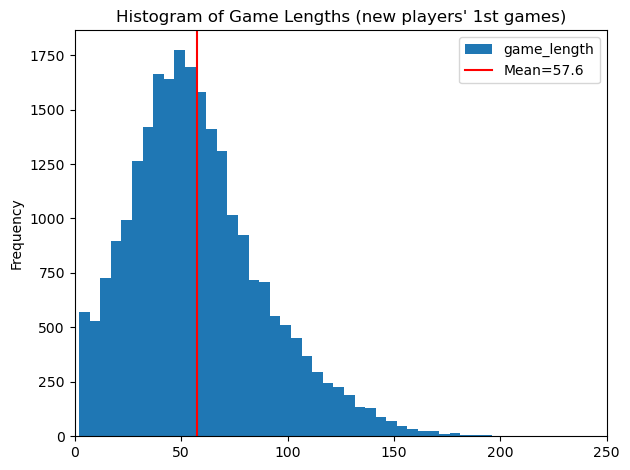

In [58]:
games_1st['game_length'].plot(kind='hist', xlim=[0,250], bins=50)
plt.title("Histogram of Game Lengths (new players' 1st games)");
plt.axvline(games_1st['game_length'].mean(), color='r', label=f"Mean={round(games_1st['game_length'].mean(), 1)}");
plt.legend();
plt.tight_layout();
plt.savefig('../images/game_lengths_1.jpg');

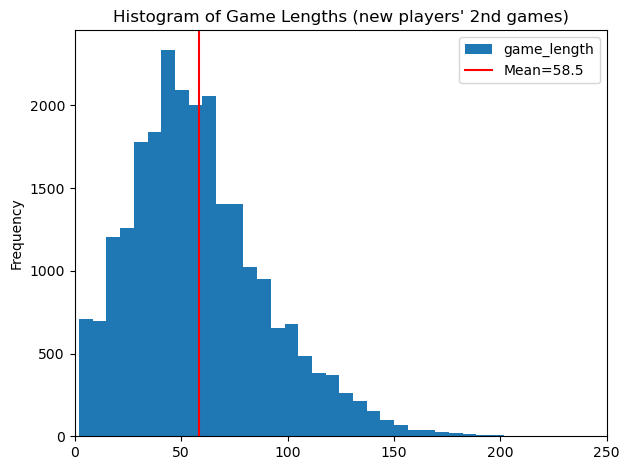

In [59]:
games_2nd['game_length'].plot(kind='hist', xlim=[0,250], bins=50)
plt.title("Histogram of Game Lengths (new players' 2nd games)");
plt.axvline(games_2nd['game_length'].mean(), color='r', label=f"Mean={round(games_2nd['game_length'].mean(), 1)}");
plt.legend();
plt.tight_layout();
plt.savefig('../images/game_lengths_2.jpg');

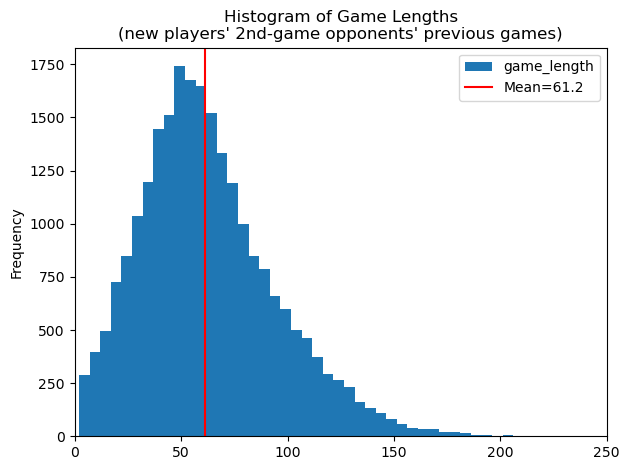

In [60]:
#For the 2nd-game opponents of new players, only plot game lengths for those opponents
#that DID play a game prior to playing the new player (in her 2nd game)
games_opp[games_opp['game_length']>0]['game_length'].plot(kind='hist', xlim=[0,250], bins=50)
plt.title("Histogram of Game Lengths\n(new players' 2nd-game opponents' previous games)");
plt.axvline(games_opp['game_length'].mean(), color='r', label=f"Mean={round(games_opp['game_length'].mean(), 1)}");
plt.legend();
plt.tight_layout();
plt.savefig('../images/game_lengths_opp.jpg');

## Adding in a column for whether the game ended in checkmate or concession

In [61]:
conceded_proportions = []

for df in games_1st, games_2nd, games_opp:
    conceded_proportions.append(df['conceded'].mean())
    
conceded_proportions

[0.6372920441442925, 0.6610113655081535, 0.6711414923406358]

# Dropping extremely short games

Any game that lasts fewer than 10 turns is likely to be not particularly predictive of future games' results.  We will thus drop any new player whose *first game* lasts fewer than 10 turns (5 moves per player):

In [62]:
#How many such new players will we be dropping in this way?
len(games_1st[games_1st['game_length']<10])

864

In [63]:
bad_inds = list(games_1st[games_1st['game_length']<10].index)

for df in games_1st, games_2nd, games_opp:
    df.drop(index=bad_inds, inplace=True)

In [64]:
len(games_1st), len(games_2nd), len(games_opp)

(23420, 23420, 23420)

### Look at the means of `conceded` and `game_length` after dropping

In [65]:
conceded_proportions = []
mean_game_lengths = []

for df in games_1st, games_2nd, games_opp:
    conceded_proportions.append(df['conceded'].mean())
    mean_game_lengths.append(df['game_length'].mean())
    
conceded_proportions

[0.6274551665243382, 0.6601195559350982, 0.6704526046114432]

As we can see, these players seem to concede about two-thirds of their games before checkmate is reached.  However, new players concede slightly less frequently during their *very first* game.

In [66]:
mean_game_lengths

[59.56682322801025, 58.95550811272417, 61.52523484201537]

The mean game length (after dropping games with fewer than 10 moves) is still about 60 for the new players' first and second games, as well as for their 2nd-game opponent's previous games.

### How many games ended in a draw?

In [67]:
draw_nums = []

for df in games_1st, games_2nd, games_opp:
    draw_nums.append(len(df[df['Result']=='1/2-1/2']))

draw_nums

[772, 857, 845]

In [68]:
#Get these numbers as proportions
[x/len(games_1st) for x in draw_nums]

[0.03296327924850555, 0.03659265584970111, 0.0360802732707088]

We see that among each type of game, between 3.3% and 3.7% of games end in a draw.

# Rename columns in terms of the new player

Rather than frame everything in terms of the "White" and "Black" players, it is more useful for us to frame everything in terms of the "new player" and "new player's opponent."  For example, instead of the columns `WhiteElo` and `BlackElo`, we should have the columns `elo` and `opponent_elo`.

In [69]:
def did_white_win(x):
    '''
    Takes a string x of the form "1-0", "0-1" or "1/2-1/2".
    Returns 1.0 if White won, 0.0 if Black won, and .5 if the game was a draw.
    '''
    if x == '1-0':
        return 1.0
    if x == '0-1':
        return 0.0
    if x == '1/2-1/2':
        return .5

### First and second games of new players

In [70]:
for df in games_1st, games_2nd:
    
    #Initialize new columns
    df['new_pl_color'] = pd.Series()
    df['opponent'] = pd.Series()
    df['new_pl_won'] = pd.Series()
    df['new_pl_elo'] = pd.Series()
    df['opp_elo'] = pd.Series()
    df['new_pl_rating_diff'] = pd.Series()
    df['opp_rating_diff'] = pd.Series()
    
    df['time_limit'] = pd.Series()
    df['time_gain_per_move'] = pd.Series()
    
    #Loop over the rows
    for ind, row in df.iterrows():
        #Check whether the new player (listed in the index of this row) is White or Black this game
        is_white = (row['White']==ind)
        is_black = (row['Black']==ind)
        
        #Make sure we've identified the player in the index as either the White or Black player (and not both)
        if (not (is_white or is_black)) or (is_white and is_black):
            raise ValueError('Could not uniquely find name of new player among White and Black players')
        
        #Get the correct names and set the correct outcome of the game
        if is_white:
            new_pl = 'White'
            opponent = 'Black'
            df.at[ind, 'new_pl_won'] = did_white_win(row['Result'])
        if is_black:
            new_pl = 'Black'
            opponent = 'White'
            df.at[ind, 'new_pl_won'] = 1.0 - did_white_win(row['Result'])
            
        #Set the values appropriately in the new columns
        df.at[ind,'new_pl_color'] = new_pl
        df.at[ind,'opponent'] = row[f"{opponent}"]
        df.at[ind,'new_pl_elo'] = row[f"{new_pl}Elo"]
        df.at[ind,'opp_elo'] = row[f"{opponent}Elo"]
        df.at[ind,'new_pl_rating_diff'] = row[f"{new_pl}RatingDiff"]
        df.at[ind,'opp_rating_diff'] = row[f"{opponent}RatingDiff"]
        
        #Also, split up the `TimeControl` column into the time limit and the clock increment per move
        df.at[ind,'time_limit'] = int(row['TimeControl'].split('+')[0])
        df.at[ind,'time_gain_per_move'] = int(row['TimeControl'].split('+')[1])


In [71]:
#Check that everything based on the players was transferred properly
games_1st.drop(columns=['time_limit', 'time_gain_per_move']).head()
#Look at the first several and last several columns of these games to see that it worked!

,Event,White,Black,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,TimeControl,Termination,...,both_players_1st_game,game_length,conceded,new_pl_color,opponent,new_pl_won,new_pl_elo,opp_elo,new_pl_rating_diff,opp_rating_diff
name_of_pl_playing_1st_game,,,,,,,,,,,,,,,,,,,,,
sereno,Classical,fabikim,sereno,1-0,1630,1500,7.0,-7.0,420+5,Normal,...,0,69,1,Black,fabikim,0.0,1500.0,1630.0,-7.0,7.0
Veska,Classical,daan1982,Veska,1-0,1734,1500,4.0,-87.0,120+10,Time forfeit,...,0,49,1,Black,daan1982,0.0,1500.0,1734.0,-87.0,4.0
OhNoYouDidnt,Bullet,bianca2107,OhNoYouDidnt,0-1,1550,1500,-21.0,13.0,120+0,Time forfeit,...,0,42,1,Black,bianca2107,1.0,1500.0,1550.0,13.0,-21.0
Kevpod,Bullet,Kevpod,SOLODSV72,0-1,1500,1359,-260.0,9.0,120+0,Time forfeit,...,0,50,1,White,SOLODSV72,0.0,1500.0,1359.0,-260.0,9.0
Jesu,Classical,Jesu,mostafaman,0-1,1500,1477,-183.0,23.0,480+0,Normal,...,0,98,0,White,mostafaman,0.0,1500.0,1477.0,-183.0,23.0


In [72]:
#Look at some rows corresponding to games that were a draw
games_1st[games_1st['Result']=='1/2-1/2'].drop(columns=['time_limit', 'time_gain_per_move']).head()

,Event,White,Black,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,TimeControl,Termination,...,both_players_1st_game,game_length,conceded,new_pl_color,opponent,new_pl_won,new_pl_elo,opp_elo,new_pl_rating_diff,opp_rating_diff
name_of_pl_playing_1st_game,,,,,,,,,,,,,,,,,,,,,
ViklunDtv,Blitz,jacek-k-37,ViklunDtv,1/2-1/2,1532,1500,0.0,16.0,300+0,Normal,...,0,136,1,Black,jacek-k-37,0.5,1500.0,1532.0,16.0,0.0
Voltair,Bullet,BrazilianStorm,Voltair,1/2-1/2,1274,1500,3.0,-117.0,30+3,Normal,...,0,66,1,Black,BrazilianStorm,0.5,1500.0,1274.0,-117.0,3.0
VANY11A,Classical,VANY11A,Enconuta,1/2-1/2,1500,1459,-20.0,1.0,600+0,Time forfeit,...,0,124,1,White,Enconuta,0.5,1500.0,1459.0,-20.0,1.0
sidinei,Classical,sidinei,Hektorhr3,1/2-1/2,1500,1493,-4.0,0.0,600+0,Normal,...,0,104,1,White,Hektorhr3,0.5,1500.0,1493.0,-4.0,0.0
chucho99,Classical,FedeGarcia,chucho99,1/2-1/2,1198,1500,26.0,-7.0,720+12,Time forfeit,...,0,110,1,Black,FedeGarcia,0.5,1500.0,1198.0,-7.0,26.0


In [73]:
#Look at the `TimeControl` column vs. our new time columns
games_1st[['TimeControl', 'time_limit', 'time_gain_per_move']].head()

,TimeControl,time_limit,time_gain_per_move
name_of_pl_playing_1st_game,,,
sereno,420+5,420.0,5.0
Veska,120+10,120.0,10.0
OhNoYouDidnt,120+0,120.0,0.0
Kevpod,120+0,120.0,0.0
Jesu,480+0,480.0,0.0


### Games played by new players' 2nd-game opponents immediately beforehand

In [74]:
#Initialize new columns
games_opp['opp_of_new_pl'] = pd.Series()
games_opp['opp_of_opp'] = pd.Series()
games_opp['opp_color'] = pd.Series()
games_opp['opp_won'] = pd.Series()
games_opp['opp_elo'] = pd.Series()
games_opp['opp_opp_elo'] = pd.Series()
games_opp['opp_rating_diff'] = pd.Series()
games_opp['opp_opp_rating_diff'] = pd.Series()

games_opp['time_limit'] = pd.Series()
games_opp['time_gain_per_move'] = pd.Series()
    
for ind, row in games_opp.iterrows():
    #If this row corresponds to a nonexistent game, skip it
    if pd.isnull(row['AN']):
        continue
    
    #Get the name of the user who's going to be the new player's opponent next game
    opp_name = row['user_to_play_new_pl_next_game']
    
    #Check whether this "opponent" (of the new player) is White or Black this game
    is_white = (row['White']==opp_name)
    is_black = (row['Black']==opp_name)
        
    #Make sure we've identified this player as either the White or Black player (and not both)
    if (not (is_white or is_black)) or (is_white and is_black):
        raise ValueError("Could not uniquely find name of new player's opponent among White and Black players")
        
    #Get the correct names and set the correct outcome of the game
    if is_white:
        opp = 'White'
        opp_opp = 'Black'
        games_opp.at[ind, 'opp_won'] = did_white_win(row['Result'])
        
    if is_black:
        opp = 'Black'
        opp_opp = 'White'
        games_opp.at[ind, 'opp_won'] = 1.0 - did_white_win(row['Result'])
            
    #Set the values appropriately in the new columns
    games_opp.at[ind,'opp_of_new_pl'] = opp_name
    games_opp.at[ind,'opp_of_opp'] = row[opp_opp]
    games_opp.at[ind,'opp_color'] = opp
    games_opp.at[ind,'opp_elo'] = row[f"{opp}Elo"]
    games_opp.at[ind,'opp_opp_elo'] = row[f"{opp_opp}Elo"]
    games_opp.at[ind,'opp_rating_diff'] = row[f"{opp}RatingDiff"]
    games_opp.at[ind,'opp_opp_rating_diff'] = row[f"{opp_opp}RatingDiff"]
    
    #Also, split up the `TimeControl` column into the time limit and the clock increment per move
    games_opp.at[ind,'time_limit'] = int(row['TimeControl'].split('+')[0])
    games_opp.at[ind,'time_gain_per_move'] = int(row['TimeControl'].split('+')[1])

In [75]:
#Check that everything was transferred properly
games_opp.drop(columns=['Event', 'TimeControl', 'Termination', 'AN', 'time_limit', 'time_gain_per_move']).head()
#Look at the first several and last several columns of these games to see that it worked!

,White,Black,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,datetime,timestamp,user_to_play_new_pl_next_game,...,game_length,conceded,opp_of_new_pl,opp_of_opp,opp_color,opp_won,opp_elo,opp_opp_elo,opp_rating_diff,opp_opp_rating_diff
new_pl_to_be_played_next_game,,,,,,,,,,,,,,,,,,,,,
farfalla,Claudiosparov,gonzo0506,0-1,1432.0,1355.0,-14.0,13.0,2016-06-30 22:01:02,1.467324e+09,gonzo0506,...,47,1,gonzo0506,Claudiosparov,Black,1.0,1355.0,1432.0,13.0,-14.0
aluis,dn23,aluis,0-1,1509.0,1500.0,-19.0,183.0,2016-06-30 22:02:44,1.467324e+09,dn23,...,46,1,dn23,aluis,White,0.0,1509.0,1500.0,-19.0,183.0
sereno,Wolf92,David177,1-0,1723.0,1289.0,2.0,-2.0,2016-06-30 22:05:14,1.467324e+09,Wolf92,...,27,0,Wolf92,David177,White,1.0,1723.0,1289.0,2.0,-2.0
joselock,Kostas3360,C4stro,1-0,1343.0,1204.0,11.0,-8.0,2016-06-30 22:05:54,1.467324e+09,C4stro,...,43,0,C4stro,Kostas3360,Black,0.0,1204.0,1343.0,-8.0,11.0
casperownd,rodrigokenji,eilandje,0-1,1454.0,1517.0,-16.0,10.0,2016-06-30 22:06:42,1.467324e+09,eilandje,...,132,0,eilandje,rodrigokenji,Black,1.0,1517.0,1454.0,10.0,-16.0


In [76]:
#Look at some rows corresponding to games that were a draw
games_opp[games_opp['Result']=='1/2-1/2'].drop(columns=['Event', 'TimeControl', 'Termination', 'AN', 'time_limit', 'time_gain_per_move']).head()

,White,Black,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,datetime,timestamp,user_to_play_new_pl_next_game,...,game_length,conceded,opp_of_new_pl,opp_of_opp,opp_color,opp_won,opp_elo,opp_opp_elo,opp_rating_diff,opp_opp_rating_diff
new_pl_to_be_played_next_game,,,,,,,,,,,,,,,,,,,,,
Voltair,alecs469,haplin,1/2-1/2,1390.0,1294.0,-3.0,3.0,2016-06-30 23:04:23,1.467328e+09,haplin,...,83,1,haplin,alecs469,Black,0.5,1294.0,1390.0,3.0,-3.0
Mohammadchess17,Mikel_1993,aisscovie,1/2-1/2,1512.0,1612.0,3.0,-3.0,2016-06-30 23:09:34,1.467328e+09,Mikel_1993,...,102,1,Mikel_1993,aisscovie,White,0.5,1512.0,1612.0,3.0,-3.0
otger,nin1877,cnnfoxmsn1,1/2-1/2,1570.0,1554.0,-1.0,0.0,2016-06-30 23:45:34,1.467330e+09,nin1877,...,101,1,nin1877,cnnfoxmsn1,White,0.5,1570.0,1554.0,-1.0,0.0
VANY11A,VANY11A,Enconuta,1/2-1/2,1500.0,1459.0,-20.0,1.0,2016-06-30 23:58:32,1.467331e+09,Enconuta,...,124,1,Enconuta,VANY11A,Black,0.5,1459.0,1500.0,1.0,-20.0
cugi061282,fahem,sharket,1/2-1/2,1135.0,1496.0,69.0,-7.0,2016-07-01 01:14:03,1.467336e+09,fahem,...,32,1,fahem,sharket,White,0.5,1135.0,1496.0,69.0,-7.0


In [77]:
#Look at the `TimeControl` column vs. our new time columns
games_opp[['TimeControl', 'time_limit', 'time_gain_per_move']].head()

,TimeControl,time_limit,time_gain_per_move
new_pl_to_be_played_next_game,,,
farfalla,600+0,600.0,0.0
aluis,300+10,300.0,10.0
sereno,600+0,600.0,0.0
joselock,300+0,300.0,0.0
casperownd,1500+3,1500.0,3.0


In [78]:
games_opp.columns

Index(['Event', 'White', 'Black', 'Result', 'WhiteElo', 'BlackElo',
       'WhiteRatingDiff', 'BlackRatingDiff', 'TimeControl', 'Termination',
       'AN', 'datetime', 'timestamp', 'user_to_play_new_pl_next_game',
       'both_users_to_play_new_pl_next', '2nd_game_opp_had_no_previous_game',
       'game_length', 'conceded', 'opp_of_new_pl', 'opp_of_opp', 'opp_color',
       'opp_won', 'opp_elo', 'opp_opp_elo', 'opp_rating_diff',
       'opp_opp_rating_diff', 'time_limit', 'time_gain_per_move'],
      dtype='object')

In [79]:
#Look at some rows corresponding to nonexistent "previous games"
games_opp[games_opp['2nd_game_opp_had_no_previous_game']==1].head()

,Event,White,Black,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,TimeControl,Termination,...,opp_of_new_pl,opp_of_opp,opp_color,opp_won,opp_elo,opp_opp_elo,opp_rating_diff,opp_opp_rating_diff,time_limit,time_gain_per_move
new_pl_to_be_played_next_game,,,,,,,,,,,,,,,,,,,,,
xmen3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alfa_khoirin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Manilkin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
felipegamba45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ueber-Ich,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Delete superfluous columns, and rename and reorder columns

In [80]:
#Drop the old columns now that we have extracted their information
for df in games_1st, games_2nd, games_opp:
    df.drop(columns=['White', 'Black', 'Result', 'WhiteElo', 'BlackElo', \
                     'WhiteRatingDiff', 'BlackRatingDiff', 'TimeControl'],
            inplace=True)
    
    #Rename the other columns
    df.rename(columns={'Event':'event', 'Termination':'termination', 'AN':'moves'}, inplace=True)

In [81]:
#Delete this superfluous column since we stored its information in 'opp_of_new_pl'
games_opp.drop(columns='user_to_play_new_pl_next_game', inplace=True)

### Re-order the columns

#### First and second games of new players

In [82]:
games_1st.columns

Index(['event', 'termination', 'moves', 'datetime', 'timestamp',
       'both_players_1st_game', 'game_length', 'conceded', 'new_pl_color',
       'opponent', 'new_pl_won', 'new_pl_elo', 'opp_elo', 'new_pl_rating_diff',
       'opp_rating_diff', 'time_limit', 'time_gain_per_move'],
      dtype='object')

In [83]:
ordered_columns = ['opponent', 'new_pl_color', 'new_pl_won', 'new_pl_elo', 'opp_elo', 'new_pl_rating_diff', \
                    'opp_rating_diff', 'game_length', 'time_limit', 'time_gain_per_move', 'event', \
                    'termination', 'conceded', 'datetime', 'timestamp', 'moves']

In [84]:
#There should only be one column that we didn't name, i.e. "both_players_1st_game"
len(games_1st.columns) - len(ordered_columns)

1

In [85]:
#Re-order the columns
games_1st = games_1st[ordered_columns+['both_players_1st_game']]
games_2nd = games_2nd[ordered_columns+['both_players_2nd_game']]

In [86]:
#Check that things are correct
games_1st.head(1)

,opponent,new_pl_color,new_pl_won,new_pl_elo,opp_elo,new_pl_rating_diff,opp_rating_diff,game_length,time_limit,time_gain_per_move,event,termination,conceded,datetime,timestamp,moves,both_players_1st_game
name_of_pl_playing_1st_game,,,,,,,,,,,,,,,,,
sereno,fabikim,Black,0.0,1500.0,1630.0,-7.0,7.0,69,420.0,5.0,Classical,Normal,1,2016-06-30 22:00:02,1.467324e+09,e4 e5 Nf3 d6 Bc4 Nc6 d3 Na5 Na3 Nxc4 Nxc4 a6 N...,0


This looks *nice*.

In [87]:
#Check that things are correct
games_2nd.head(1)

,opponent,new_pl_color,new_pl_won,new_pl_elo,opp_elo,new_pl_rating_diff,opp_rating_diff,game_length,time_limit,time_gain_per_move,event,termination,conceded,datetime,timestamp,moves,both_players_2nd_game
name_of_pl_playing_2nd_game,,,,,,,,,,,,,,,,,
Kevpod,ale19,White,0.0,1500.0,1412.0,-222.0,9.0,78,300.0,1.0,Blitz,Time forfeit,1,2016-06-30 22:06:12,1.467324e+09,d4 Nf6 Nf3 Ne4 e3 c6 Bd3 Nxf2 Kxf2 Qc7 Nc3 e6 ...,0


This also looks good.

#### New players' 2nd-game opponents' previous games

In [88]:
games_opp.columns

Index(['event', 'termination', 'moves', 'datetime', 'timestamp',
       'both_users_to_play_new_pl_next', '2nd_game_opp_had_no_previous_game',
       'game_length', 'conceded', 'opp_of_new_pl', 'opp_of_opp', 'opp_color',
       'opp_won', 'opp_elo', 'opp_opp_elo', 'opp_rating_diff',
       'opp_opp_rating_diff', 'time_limit', 'time_gain_per_move'],
      dtype='object')

In [89]:
ordered_cols = ['opp_of_new_pl', 'opp_of_opp', 'opp_color', 'opp_won', 'opp_elo', 'opp_opp_elo', \
                'opp_rating_diff', 'opp_opp_rating_diff', 'game_length', 'time_limit', 'time_gain_per_move', \
                'event', 'termination', 'conceded', 'datetime', 'timestamp', 'moves', \
                'both_users_to_play_new_pl_next', '2nd_game_opp_had_no_previous_game']

In [90]:
set(games_opp.columns) == set(ordered_cols)

True

In [91]:
games_opp = games_opp[ordered_cols]

In [92]:
#Check that things are correct
games_opp.head(1)

,opp_of_new_pl,opp_of_opp,opp_color,opp_won,opp_elo,opp_opp_elo,opp_rating_diff,opp_opp_rating_diff,game_length,time_limit,time_gain_per_move,event,termination,conceded,datetime,timestamp,moves,both_users_to_play_new_pl_next,2nd_game_opp_had_no_previous_game
new_pl_to_be_played_next_game,,,,,,,,,,,,,,,,,,,
farfalla,gonzo0506,Claudiosparov,Black,1.0,1355.0,1432.0,13.0,-14.0,47,600.0,0.0,Classical,Normal,1,2016-06-30 22:01:02,1.467324e+09,a3 d5 b4 b5 Bb2 Nc6 e3 e5 d4 e4 f3 Bf5 g4 Qh4+...,0,0


# Double-Check the Data Types and Missing Values

In [93]:
games_1st.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23420 entries, sereno to CLauDio989N
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   opponent               23420 non-null  object 
 1   new_pl_color           23420 non-null  object 
 2   new_pl_won             23420 non-null  float64
 3   new_pl_elo             23420 non-null  float64
 4   opp_elo                23420 non-null  float64
 5   new_pl_rating_diff     23420 non-null  float64
 6   opp_rating_diff        23420 non-null  float64
 7   game_length            23420 non-null  int64  
 8   time_limit             23420 non-null  float64
 9   time_gain_per_move     23420 non-null  float64
 10  event                  23420 non-null  object 
 11  termination            23420 non-null  object 
 12  conceded               23420 non-null  int64  
 13  datetime               23420 non-null  object 
 14  timestamp              23420 non-null  float64
 

In [94]:
games_2nd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23420 entries, Kevpod to silvificknigthchess9
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   opponent               23420 non-null  object 
 1   new_pl_color           23420 non-null  object 
 2   new_pl_won             23420 non-null  float64
 3   new_pl_elo             23420 non-null  float64
 4   opp_elo                23420 non-null  float64
 5   new_pl_rating_diff     23420 non-null  float64
 6   opp_rating_diff        23420 non-null  float64
 7   game_length            23420 non-null  int64  
 8   time_limit             23420 non-null  float64
 9   time_gain_per_move     23420 non-null  float64
 10  event                  23420 non-null  object 
 11  termination            23420 non-null  object 
 12  conceded               23420 non-null  int64  
 13  datetime               23420 non-null  object 
 14  timestamp              23420 non-null  

In [95]:
games_opp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23420 entries, farfalla to hoholupus
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   opp_of_new_pl                      22974 non-null  object 
 1   opp_of_opp                         22974 non-null  object 
 2   opp_color                          22974 non-null  object 
 3   opp_won                            22974 non-null  float64
 4   opp_elo                            22974 non-null  float64
 5   opp_opp_elo                        22974 non-null  float64
 6   opp_rating_diff                    22974 non-null  float64
 7   opp_opp_rating_diff                22974 non-null  float64
 8   game_length                        23420 non-null  int64  
 9   time_limit                         22974 non-null  float64
 10  time_gain_per_move                 22974 non-null  float64
 11  event                              22974 non-nul

# Train / Test / Validate Split

We will reserve 1500 new players for test data and another 1500 new players for validation data.  We will use the test data to help select between our models, but we will not look at the validation data until we have identified our production model.

The most imbalanced of the categorical variables in our dataframes is the `2nd_game_opp_had_no_previous_game` variable from the dataframe of the new players' 2nd-game opponents' previous games:

In [96]:
games_opp['2nd_game_opp_had_no_previous_game'].value_counts(normalize=True)

0    0.980956
1    0.019044
Name: 2nd_game_opp_had_no_previous_game, dtype: float64

That is, fewer than 2% of the 23420 new players had a 2nd-game opponent who had *no* previous games this month.  We will therefore stratify our random train/test/validate split by this variable. 

In [97]:
#Take off 3000 new players for test and validation data
train_opp, test_opp = train_test_split(games_opp,
                                       random_state = 123,
                                       stratify = games_opp['2nd_game_opp_had_no_previous_game'],
                                       test_size = 3000)

In [98]:
#Split these 3000 new players into 1500 for test data and 1500 for validation data
test_opp, val_opp = train_test_split(test_opp,
                                       random_state = 42,
                                       stratify = test_opp['2nd_game_opp_had_no_previous_game'],
                                       test_size = 1500)

In [99]:
#Check that the data were properly split up
len(train_opp), len(test_opp), len(val_opp)

(20420, 1500, 1500)

In [100]:
train_inds = train_opp.index
test_inds = test_opp.index
val_inds = val_opp.index

In [101]:
#Split up the new players' 1st and 2nd games into the same train/test/validate groups
train_1st = games_1st.loc[train_inds]
test_1st = games_1st.loc[test_inds]
val_1st = games_1st.loc[val_inds]

train_2nd = games_2nd.loc[train_inds]
test_2nd = games_2nd.loc[test_inds]
val_2nd = games_2nd.loc[val_inds]

In [102]:
#Check lengths of 1st-game datasets
len(train_1st), len(test_1st), len(val_1st)

(20420, 1500, 1500)

In [103]:
#Check lengths of 2nd-game datasets
len(train_2nd), len(test_2nd), len(val_2nd)

(20420, 1500, 1500)

In [104]:
#Look at a few rows - they should no longer be sorted by timestamp
train_1st.head(3)

,opponent,new_pl_color,new_pl_won,new_pl_elo,opp_elo,new_pl_rating_diff,opp_rating_diff,game_length,time_limit,time_gain_per_move,event,termination,conceded,datetime,timestamp,moves,both_players_1st_game
new_pl_to_be_played_next_game,,,,,,,,,,,,,,,,,
SAKATBIRAKAN,maxmorpheus,White,1.0,1500.0,1417.0,138.0,-6.0,65,480.0,5.0,Classical,Normal,0,2016-07-13 19:55:19,1.468440e+09,e4 e5 Nf3 Nc6 Bb5 a6 Ba4 b5 Bb3 Qe7 Nc3 Nb4 a3...,0
bv44,ATMarley12,White,1.0,1500.0,1445.0,150.0,-6.0,15,480.0,0.0,Classical,Normal,1,2016-07-19 14:57:47,1.468940e+09,e4 e5 Bc4 Nf6 Nf3 Nxe4 Qe2 d5 Bb3 Qf6 Nc3 Bf5 ...,0
mister_fix_it,koha,White,1.0,1500.0,1522.0,186.0,-7.0,41,600.0,2.0,Classical,Time forfeit,1,2016-07-15 08:51:17,1.468573e+09,e4 e5 Nf3 Nc6 Bb5 a6 Ba4 b5 Bb3 h6 c3 Nf6 O-O ...,0


In [105]:
test_2nd.head(3)

,opponent,new_pl_color,new_pl_won,new_pl_elo,opp_elo,new_pl_rating_diff,opp_rating_diff,game_length,time_limit,time_gain_per_move,event,termination,conceded,datetime,timestamp,moves,both_players_2nd_game
new_pl_to_be_played_next_game,,,,,,,,,,,,,,,,,
SsAaRrAa,evgenyi,Black,0.0,1677.0,1667.0,-117.0,26.0,103,1500.0,0.0,Classical,Normal,0,2016-07-05 17:34:02,1.467740e+09,e4 e5 Nf3 Nc6 d4 Nf6 dxe5 Nxe4 Qe2 d5 g3 Bc5 B...,0
BSB17,gmatrix,White,0.0,1341.0,1718.0,-31.0,4.0,74,900.0,0.0,Classical,Normal,0,2016-07-06 20:45:20,1.467838e+09,Nf3 e6 g3 d5 Bg2 Nf6 O-O Nc6 d3 Be7 Nbd2 O-O e...,0
BeautifulBot,enzo1970,Black,1.0,1382.0,1720.0,266.0,-15.0,66,60.0,0.0,Bullet,Time forfeit,1,2016-07-04 13:03:20,1.467637e+09,Nf3 c5 d4 b6 d5 e6 d6 g6 e4 Bg7 e5 Nc6 Bf4 Bb7...,0


In [106]:
val_opp.head(3)

,opp_of_new_pl,opp_of_opp,opp_color,opp_won,opp_elo,opp_opp_elo,opp_rating_diff,opp_opp_rating_diff,game_length,time_limit,time_gain_per_move,event,termination,conceded,datetime,timestamp,moves,both_users_to_play_new_pl_next,2nd_game_opp_had_no_previous_game
new_pl_to_be_played_next_game,,,,,,,,,,,,,,,,,,,
noobstyle,puffknuckle,pexon77,Black,0.0,1640.0,1759.0,-7.0,8.0,77,600.0,0.0,Classical,Time forfeit,1,2016-07-26 06:27:48,1.469514e+09,e4 d6 f4 Nf6 d3 Nc6 c3 h6 Nf3 e6 Na3 d5 e5 Nd7...,0,0
DeepEjaculater,MolonLabe,DeepEjaculater,Black,0.0,1609.0,1500.0,-9.0,238.0,27,120.0,0.0,Bullet,Normal,0,2016-07-08 14:22:58,1.467988e+09,d4 d6 Nf3 Nd7 Nc3 e5 e4 Ngf6 dxe5 dxe5 Bc4 g6 ...,0,0
Schlafmaus,Lachen,loneknight,White,0.0,1361.0,1505.0,-7.0,7.0,70,300.0,0.0,Blitz,Time forfeit,1,2016-07-07 22:34:20,1.467931e+09,e4 e5 Nf3 d6 Bc4 Nf6 c3 c6 Ng5 d5 exd5 cxd5 Bb...,0,0


In [107]:
#Export all the dataframes as CSVs
index_names_dict = {
    '1st':'name_of_pl_playing_1st_game',
    '2nd':'name_of_pl_playing_2nd_game',
    'opp':'new_pl_to_be_played_next_game'
}

for ttv, kind in itertools.product(['train', 'test', 'val'], ['1st', '2nd', 'opp']):
    locals()[f"{ttv}_{kind}"].to_csv(f"../data/processed/{ttv}/{ttv}_{kind}.csv",
                                    index_label = index_names_dict[kind])